# Kickstarter Project Basismodel

In thise notebook we need to take some information from our first notebook "kickstarter EDA" for the Setup & Data Preparation. After that we will start with two Basis-Models. In this case **logistic regression** and **random forest**. 

So you can skip the first part as it's just some repition from our EDA notebook. Jump right into the models [here](#model).

# Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sms
import copy
import glob

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from IPython.display import Image
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.datasets import load_boston
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import PolynomialFeatures
from scipy.special import boxcox1p
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
#tabelle = pd.read_excel('List_features_EDA.xlsx', sheet_name = 'Jupyter', na_values = ['.','*'])

In [3]:
# get data file names
path =r'/Users/raphaelaboll/nf-sep-20/Project_2/data'
filenames = glob.glob(path + "/*.csv")
dfs = []
for filename in filenames:
       dfs.append(pd.read_csv(filename))
# Concatenate all data into one DataFrame
df = pd.concat(dfs, ignore_index=True)

# Data Cleaning

## Check for nullvalues
As we can see the following features *friends, is_backing, is_starred and permissions* can be dropped due to missing data issue.

In [4]:
# checking null values
nan = pd.DataFrame(df.isnull().sum(),columns=['Count'])
nan['Percentage'] = round(nan.Count/df.shape[0]*100,1)
print(nan[nan.Count!=0])

              Count  Percentage
blurb             8         0.0
friends      208922        99.9
is_backing   208922        99.9
is_starred   208922        99.9
location        226         0.1
permissions  208922        99.9
usd_type        480         0.2


## Check for duplicates
No relevant duplicate.

In [5]:
# generate count statistics of duplicate entries
if len(df[df.duplicated()]) > 0:
    print("No. of duplicated entries: ", len(df[df.duplicated()]))
    print(df[df.duplicated(keep=False)].sort_values(by=list(df.columns)).head())
else:
    print("No duplicated entries found")

No duplicated entries found


## Check and change of the datatypes

### Datetime Issues
We changed the features *deadline* and *launched_at* and created a new feature *duration*. The dates created_at and state_changed_at will be dropped.

In [6]:
# change Date-times deadline
df['deadline'] = pd.to_datetime(df['deadline'], unit='s')

In [7]:
# split date to year and month and delete deadline later 
df['year_deadline'] = df['deadline'].dt.year 
df['month_deadline'] = df['deadline'].dt.month 
df['day_deadline'] = df['deadline'].dt.day
df['time_deadline'] = df['deadline'].dt.time

In [8]:
# change Date-times launched_at
df['launched_at'] = pd.to_datetime(df['launched_at'], unit='s')

In [9]:
# split date to year and month and delete deadline later 
df['year_launched'] = df['launched_at'].dt.year 
df['month_launched'] = df['launched_at'].dt.month 
df['day_launched'] = df['launched_at'].dt.day
df['time_launched'] = df['launched_at'].dt.time

In [10]:
# Launch day of week
df['day_launched'] = df['launched_at'].dt.weekday_name
df.day_launched.value_counts()

Tuesday      43340
Monday       36958
Wednesday    36593
Thursday     31953
Friday       31051
Saturday     16184
Sunday       13143
Name: day_launched, dtype: int64

##  Changing data due to inconsistency reasons

### goal_USD


In [11]:
# The information in feature goal has different currencies. This needs to be changed
df["goal_usd"]=df["goal"]*df["static_usd_rate"]

### state (target variable)
We only consider the states which can be used for predictions.

In [12]:
# We only consider the states which can be used for prediction
df.query("state in ['failed','successful']", inplace=True)

## Check for outliners
Outliners can only occur for the following features: usd_pledged, goal_usd and backers_count.

In [13]:
# check for outliners
outliners = pd.DataFrame(round(df[['usd_pledged','goal_usd','backers_count']].describe(percentiles=[0.25, 0.5, 
                                                                                                    0.75, 0.9, 0.95,0.99]),1))
outliners

,usd_pledged,goal_usd,backers_count
count,192664.0,192664.0,192664.0
mean,13516.7,37787.7,152.6
std,89184.0,1065708.8,898.3
min,0.0,0.0,0.0
25%,150.0,1500.0,4.0
50%,1772.0,5000.0,30.0
75%,7096.6,12447.0,94.2
90%,21459.6,33612.6,255.0
95%,42758.6,60000.0,506.0
99%,189111.4,250000.0,2072.4


In [14]:
df_outliners_99=df.query("usd_pledged<189111.4	and goal_usd<250000.0 and backers_count<2072.4")
df_outliners_99.shape[0]/ df.shape[0]

0.9757868621018976

In [15]:
df=df_outliners_99

## Datasplit

We will split the feature *category* to a new feature *Sub- and Maincategory*.

In [16]:
# split column category
import ast
df_cat = (pd.DataFrame(df['category'].apply(ast.literal_eval).values.tolist()))

In [17]:
# New Column subcategory_name
df["subcategory_name"]=df_cat.name
df.subcategory_name.head()

1               Rock
2      Playing Cards
3         Nonfiction
4    Classical Music
5    Classical Music
Name: subcategory_name, dtype: object

In [18]:
# new column maincategory
df["maincategory"]=df_cat.parent_id
df.maincategory.fillna(0,inplace=True)
df.maincategory.astype(int)

1         14
2         12
3         18
4         14
5         14
6          0
7         17
8          9
9         10
10        18
11        14
13        18
14        17
15        15
16        10
17        17
18        18
19         9
20        14
21        18
22         1
23         0
24         9
25        10
26        14
28        16
29         0
30        12
31        18
32         1
          ..
209192     0
209193     0
209194     0
209195     0
209196     0
209197     0
209198     0
209199     0
209200     0
209201     0
209202     0
209203     0
209204     0
209205     0
209206     0
209207     0
209208     0
209209     0
209210     0
209211     0
209212     0
209213     0
209214     0
209215     0
209216     0
209217     0
209218     0
209219     0
209220     0
209221     0
Name: maincategory, Length: 187999, dtype: int64

In [19]:
df['maincategory_name']=df.maincategory.apply(lambda x: "Art" if x==1 else "Comics" if x==3 else "Dance" if x==6 else
                                              "Design" if x==7 else "Fashion" if x==9 else "Food" if x==10 else "Film_Video" if x==11 else
                                              "Games" if x==12 else "Journalism" if x==13 else "Music" if x==14 else "Photography" 
                                              if x==15 else
                                              "Technology" if x==16 else "Theater" if x==17 else "Publisihing" if x==18 else
                                              "Crafts" if x==26 else 0)

## Check continous & category data

### Boolean features and features with only two values

In [20]:
## Boolean features: staff_picked, spotlight and currency_trailing_code can be skipped due to different reasons
df['staff_pick']=df['staff_pick'].apply(lambda x: int(x==True))

In [21]:
# change of the state to 0 and 1 
df['state_bin']=df['state'].apply(lambda x: 1 if x=='successful' else 0)

In [22]:
# set category data to type "category"
df['usd_type']=df['usd_type'].apply(lambda x: 1 if x=='international' else 0)

## Categorical features

We'll define the category data for currency, country and day_launched

In [23]:
# currency_cat
df['currency_cat']=df['currency'].apply(lambda x: 1 if x=='USD' else 2 if x=='GBP' else 3 if x=='EUR'else 4 if
                                     x=='CAD' else
                                     5 if x=='AUD' else 6 if x=='MXN' else 7 if x=='SEK' else 8)

In [24]:
# country_cat
df['country_cat']=df['country'].apply(lambda x: 1 if x=='US' else 0)

In [25]:
# day_launched
df['day_launched_cat']=df['day_launched'] .apply(lambda x: 1 if x=='Monday' else 2 if x=='Tuesday' else 3 if 
                                                x=='Wednesday' else 4 if x=='Thursday' else 5 if x=='Friday'
                                                else 6 if x=='Saturday'else 7 )

## Normalization

For the following features we use the log for normalization *goal_usd and usd_pledged*

In [26]:
# create a new feature goal_usd_log und usd_pledged_log
df["goal_usd_log"]=np.log(df.goal_usd)
df["usd_pledged_log"]=np.log(df.usd_pledged + 1)

# Summary EDA

The features can be grouped into the following groups: **amount / currency**, **campaign**, **country**, **project infos** and **time issues**. See the table below.

A couple of features can be dropped due to different reasons: duplicates (currency symbol, pledged), no needed information (converted_pledged_amount), data consistency(goal is replaced by goal_usd), no variance (is starrable, disable_communication), not filled(friends, is_backing, is_starred, permissions) and no information gain (e.g. id).
Spotlight is always true in case of a project of being successful.

We will continue with the following features:

- **duration**: new feature duration of a project , computated via lauched_at and created_at
- **year_launched**: year in which the project is launched
- **month_launched**: month in which the project is launched
- **day_launched_cat**: weekday in which the project is launched

- **maincategory_name**: category of the kickstarter project, can be splitted into main- and subcategory
- **country_cat**: category of country, 1 in case of US

- **usd_type**: type of project, 1 in case of a international project

- **backers_count**: the number of backers of the regarded project
- **staff_pick**: flag for shortfilm, 1 if exists 

- **goal_usd_log**: log of the goal of a project in USD, computated via goal*static_usd_rate
- **usd_pledged_log**: log of the goal of a project in USD, computated via goal*static_usd_rate
- **currency_cat**: category of project, 1 = USD, 2 = GBP, 3 = EUR, 4 = CAD, 5 = AUD, 6 = MXN, 7 = SEK, 8 = Others
- **static_usd_rate**: historic exchange rate


We will analyze which features have the most significant impact to the label: the success of a project (state).

# Definition of models and feature engineering

## Definition of basemodel

Our base models contains the following features: launched_year, launched_month, launched_weekday, subcategory_name, usd_type, backers_count, staff_pick, goal_usd_log, usd_pledged_log, currency_cat and static_usd_rate.

### Definition of a new dataframe and X, y

In [27]:
# Definition of X and y
df_basismodel=df[['state_bin','year_launched','month_launched', 
                  'day_launched_cat','usd_type','backers_count','staff_pick',
                  'goal_usd_log', 'usd_pledged_log', 'currency_cat','static_usd_rate','maincategory_name']]

### Correlations

<AxesSubplot:title={'center':'Korrelation nach Pearson'}>

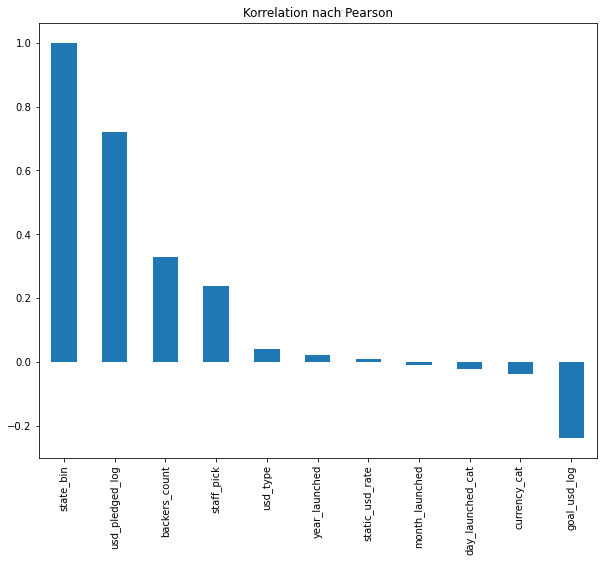

In [28]:
# correlation
basis=df_basismodel.corr(method='pearson')['state_bin'].sort_values(axis=0, ascending=False)
basis.plot(kind='bar',figsize=(10,8),title='Korrelation nach Pearson')

## Correlations with dummyvariables

In [29]:
# get dummies
main_dummy= pd.get_dummies(df_basismodel['maincategory_name'], prefix='main', drop_first=True)

In [30]:
main_dum = df_basismodel.drop(['maincategory_name'], axis=1)

In [31]:
main_dum = pd.concat([main_dum,main_dummy], axis=1)

<AxesSubplot:title={'center':'Korrelation nach Pearson'}>

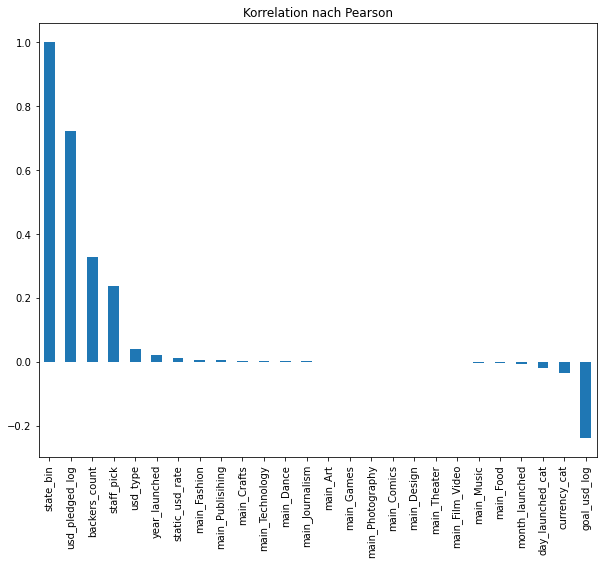

In [32]:
# correlation
basis_dum=main_dum.corr(method='pearson')['state_bin'].sort_values(axis=0, ascending=False)
basis_dum.plot(kind='bar',figsize=(10,8),title='Korrelation nach Pearson')

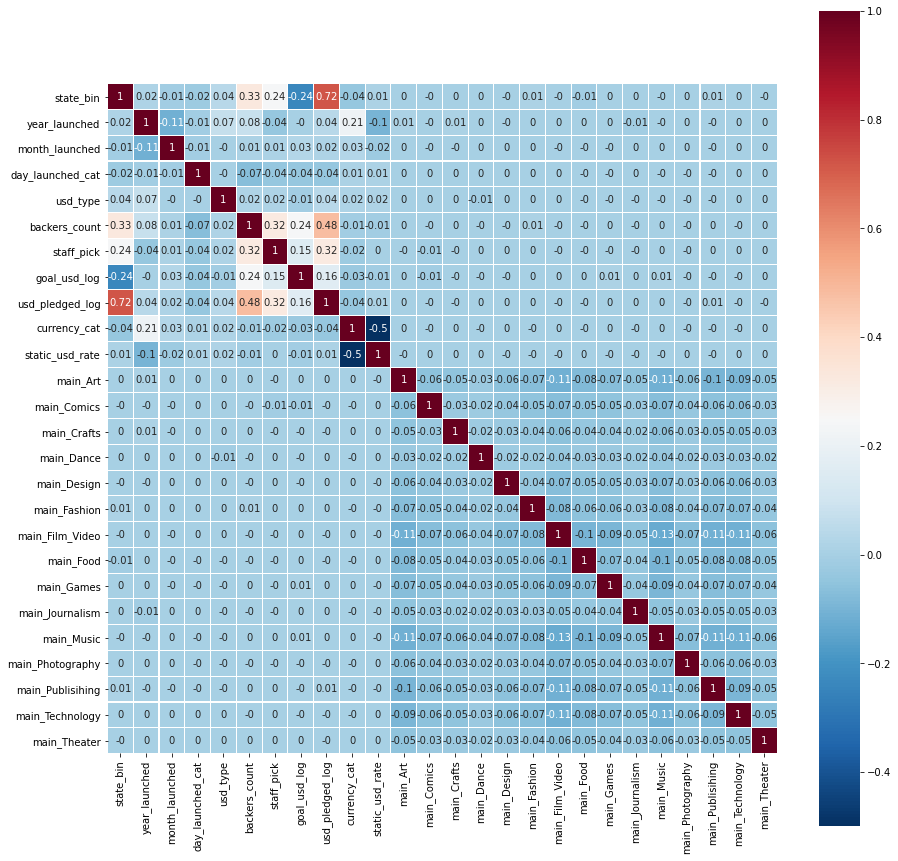

In [33]:
# heatmap - finding variables which are useful for prediction
plt.figure(figsize=(15,15))
sns.heatmap(data=main_dum.corr().round(2),annot=True,cmap='RdBu_r',linewidths=0.2,square=True);

# Modeling
<a id='model'></a>

In this section we will apply four different machine learning models for classification to the data. Our goal is to classify kickstarter projects into successesful or failed.

For each model we will evaluate the accuracy, precission and f1-score. The f1-score seems to be the most important and suitable measure, because there is no preference for false positives or false negatives (both are equally bad). 

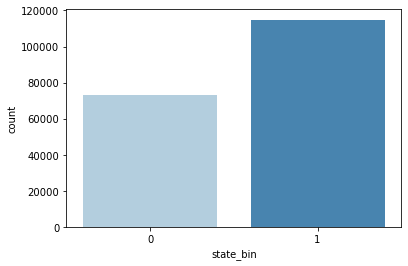

In [34]:
# countplot for our label
sns.countplot(x='state_bin',data=main_dum, palette='Blues');

In [35]:
# scaling and splittin the data into features and target label
X_unscaled = main_dum.drop(['state_bin', 'usd_pledged_log'], axis=1)
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X_unscaled), columns=list(X_unscaled.columns))
y = main_dum['state_bin'].values

In [36]:
# Train Test Split 
from sklearn.model_selection import train_test_split

# Split the features and label data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Show the results of the split
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 140999 samples.
Testing set has 47000 samples.


## Logistic Regression

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

### Feature Selection

We will start with different methods for feature selection. Feature selection methods are intended to reduce the number of input variables to those that are believed to be most useful to a model in order to predict the target variable.

In [38]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [39]:
len(main_dum.columns)

26

In [40]:
feature_name = list(df_basismodel.columns)
# no of maximum features we need to select
num_feats=10

#### Pearson Correlation 

In [41]:
def cor_selector(X, y, num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature
cor_support, cor_feature = cor_selector(X, y, num_feats)
print(str(len(cor_feature)), 'selected features')

cor_feature

10 selected features


['main_Fashion',
 'month_launched',
 'static_usd_rate',
 'day_launched_cat',
 'year_launched',
 'currency_cat',
 'usd_type',
 'staff_pick',
 'goal_usd_log',
 'backers_count']

#### Recursive Feature Elimination

In [42]:
X_norm = StandardScaler().fit_transform(X)
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_feats, step=10, verbose=5)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

rfe_feature

Fitting estimator with 24 features.
Fitting estimator with 14 features.
10 selected features


['year_launched',
 'month_launched',
 'day_launched_cat',
 'usd_type',
 'backers_count',
 'staff_pick',
 'goal_usd_log',
 'currency_cat',
 'static_usd_rate',
 'main_Games']

#### Lasso SelectFromModel

In [43]:
embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"), max_features=num_feats)
embeded_lr_selector.fit(X_norm, y)
embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

embeded_lr_feature

2 selected features


['backers_count', 'goal_usd_log']

#### Tree Based Selection

In [44]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
embeded_rf_selector.fit(X, y)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

embeded_rf_feature

2 selected features


['backers_count', 'goal_usd_log']

### Perform Logistic Regressoion

In [45]:
seed = 123

In [46]:
# set X_new after feature selection
X_new = X[['main_Fashion',
 'month_launched',
 'static_usd_rate',
 'day_launched_cat',
 'year_launched',
 'currency_cat',
 'usd_type',
 'staff_pick',
 'goal_usd_log',
 'backers_count']]

In [47]:
# train test split again with X_new
X_train,X_test,y_train,y_test = train_test_split(X_new,y,test_size=0.25,random_state=seed)

In [48]:
# Step 1: Make an instance of the Model
log_reg = LogisticRegression()

# Step 2: Train the model on the data
log_reg.fit(X_train, y_train)

# Step 3: predict the response for test data
y_pred = log_reg.predict(X_test)

In [49]:
print(log_reg.coef_.round(4))
print(log_reg.intercept_)

[[ 7.00000e-04 -4.19000e-02 -1.88000e-02  2.45000e-02 -5.09000e-02
  -7.45000e-02  5.43000e-02  3.46000e-02 -1.72830e+00  1.37875e+01]]
[4.34241074]


In [50]:
# Model Evaluation metrics 
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))

Accuracy Score : 0.9052765957446809
Precision Score : 0.91285924204627
Recall Score : 0.93353136466888
F1 Score : 0.9230795811880161


In [51]:
# show calssification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.86      0.88     18385
           1       0.91      0.93      0.92     28615

    accuracy                           0.91     47000
   macro avg       0.90      0.90      0.90     47000
weighted avg       0.90      0.91      0.90     47000



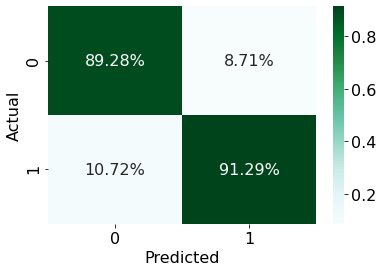

In [77]:
# confusion matrix
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True, 
            fmt='.2%',cmap='BuGn');

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.897


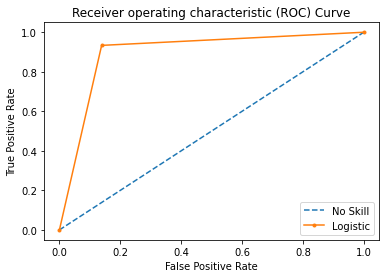

In [53]:
# take a look at TPR and TNR (AUC-ROC curve)
import matplotlib.pyplot as pyplot
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

no_skill_probs = [0 for _ in range(len(y_test))]

no_skill_auc = roc_auc_score(y_test, no_skill_probs)        
log_reg_auc = roc_auc_score(y_test, y_pred)

print('No Skill: ROC AUC=%.3f' % (no_skill_auc))        
print('Logistic: ROC AUC=%.3f' % (log_reg_auc))

no_skill_fpr, no_skill_tpr, _ = roc_curve(y_test, no_skill_probs)              
log_reg_fpr, log_reg_tpr, _ = roc_curve(y_test, y_pred)

pyplot.plot(no_skill_fpr, no_skill_tpr, linestyle='--', label='No Skill')       
pyplot.plot(log_reg_fpr, log_reg_tpr, marker='.', label='Logistic')

pyplot.xlabel('False Positive Rate')        
pyplot.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')

pyplot.legend()     

pyplot.show()

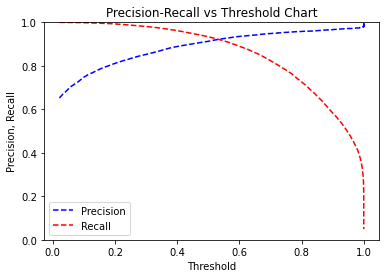

In [54]:
# check precision & recall 
from sklearn import metrics 

# Predict test_y values and probabilities based on fitted logistic 
y_probabilities=log_reg.predict_proba(X_test) 
  # probs_y is a 2-D array of probability of being labeled as 0 (first column of 
  # array) vs 1 (2nd column in array)

from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, y_probabilities[:, 
1]) 
   #retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1]);

In [55]:
# improve the model by setting the threshold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score, precision_score

THRESHOLD = 0.5

preds = np.where(log_reg.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

pd.DataFrame(data=[accuracy_score(y_test, preds), recall_score(y_test, preds),
                   precision_score(y_test, preds), roc_auc_score(y_test, preds)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"])

,0
accuracy,0.905277
recall,0.933531
precision,0.912859
roc_auc_score,0.897416


The logistic regression model has a good accuracy score of around 0.9 (weighted average F1 score = 0.91). As we can see, the ROC-AUC curve is pulled towards the top left of the graph, which is a positive sign. In the following we try to improve oir logistic regression model.

### Parameter optimisation logistic regression

Our logistic regression model can potentially be further improved by optimising its parametersm using grid search.

In [56]:
# Grid search
from sklearn.model_selection import GridSearchCV

clf = LogisticRegression(random_state = seed)
grid_values = {'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25]}
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values,scoring = 'recall')
grid_clf_acc.fit(X_train, y_train)

#Predict values based on new parameters
y_pred_acc = grid_clf_acc.predict(X_test)

# New Model Evaluation metrics 
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_acc)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_acc)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_acc)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_acc)))

Accuracy Score : 0.9053191489361702
Precision Score : 0.9129780907133336
Recall Score : 0.933461471256334
F1 Score : 0.9231061653303844


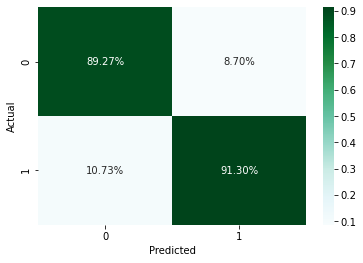

In [57]:
#Logistic Regression (Grid Search) Confusion matrix
confusion_matrix = pd.crosstab(y_test, y_pred_acc, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True, 
            fmt='.2%',cmap='BuGn');

After hyperparameter tuning, the model's accuracy and f1 score could be improved slighty.

**Before**
- Accuracy Score: 0.9052765957446809
- Precision Score: 0.91285924204627
- Recall Score: 0.93353136466888
- F1 Score: 0.9230795811880161

**After**
- Accuracy Score : 0.9053191489361702
- Precision Score : 0.9129780907133336
- Recall Score : 0.933461471256334
- F1 Score : 0.9231061653303844

## Random Forest

Random Forest is a robust machine learning algorithm that can be used for regression and classification. It is an ensemble method, meaning that a random forest model is made up of a large number of small decision trees, called estimators, which each produce their own predictions. The random forest model combines the predictions of the estimators to produce a more accurate prediction.

In [58]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

In [59]:
# Step 1: Make an instance of the Model
forest = RandomForestClassifier(random_state = seed)

# Step 2: Train the model on the data
forest.fit(X_train, y_train)

# Step 3: predict the response for test data
y_pred_rf = forest.predict(X_test)

In [60]:
n_nodes = []
max_depths = []

for ind_tree in forest.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 20639
Average maximum depth 33


In [61]:
# Model Evaluation metrics 
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_rf)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_rf)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_rf)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_rf)))

Accuracy Score : 0.9417659574468085
Precision Score : 0.9398327554558433
Recall Score : 0.966206535034073
F1 Score : 0.9528371788465183


In [62]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.95      0.90      0.92     18385
           1       0.94      0.97      0.95     28615

    accuracy                           0.94     47000
   macro avg       0.94      0.93      0.94     47000
weighted avg       0.94      0.94      0.94     47000



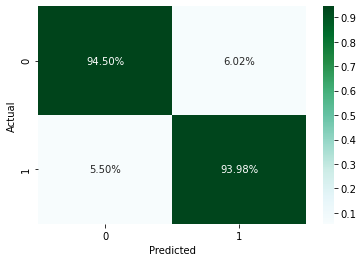

In [63]:
# confusion matrix
confusion_matrix = pd.crosstab(y_test, y_pred_rf, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True, 
            fmt='.2%',cmap='BuGn');

In [64]:
train_rf_predictions = forest.predict(X_train)
train_rf_probs = forest.predict_proba(X_train)[:, 1]

rf_predictions = forest.predict(X_test)
rf_probs = forest.predict_proba(X_test)[:, 1]

In [65]:
def evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(y_test, [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test, [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(y_test, rf_predictions)
    results['precision'] = precision_score(y_test, rf_predictions)
    results['roc'] = roc_auc_score(y_test, rf_probs)
    
    train_results = {}
    train_results['recall'] = recall_score(y_train, train_rf_predictions)
    train_results['precision'] = precision_score(y_train, train_rf_predictions)
    train_results['roc'] = roc_auc_score(y_train, train_rf_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, rf_probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

Recall Baseline: 1.0 Test: 0.97 Train: 1.0
Precision Baseline: 0.61 Test: 0.94 Train: 1.0
Roc Baseline: 0.5 Test: 0.98 Train: 1.0


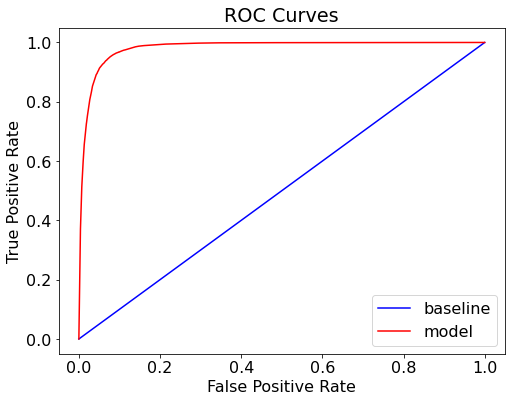

In [66]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

### Grid Search

In [67]:
# Step 1: set hyperparameter grid 
param_grid_rf = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Step 2: Make an instance of the Model
estimator = RandomForestClassifier(random_state = 1)

# Step 3: 
# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid_rf, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 10, verbose = 1, random_state=1)

# Fit 
rs.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.3min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 3, 3, 3, 4, 4, 4, 5,
                                                      5, 5, 6, 6, 6, 7, 7, 7, 8,
                                                      8, 8, 9, 9, 9, 10, 10, 10,
                                                      11, 11, 12, 12, 12, ...],
                                        'max_features': ['auto', 'sqrt', None,
                                                         0.5, 0.6, 0.7,
                                                         0.7999999999999999,
                                                         0.8999999999999999],
                                        'max_leaf_nodes': [None, 10, 10, 10, 10,
                                                           10, 10, 10, 10, 10,
                                      

In [68]:
print("Best parameters:", rs.best_params_)

Best parameters: {'n_estimators': 106, 'min_samples_split': 2, 'max_leaf_nodes': 46, 'max_features': 0.8999999999999999, 'max_depth': 15, 'bootstrap': True}


In [69]:
best_model = rs.best_estimator_

In [70]:
train_rf_predictions_new = best_model.predict(X_train)
train_rf_probs_new = best_model.predict_proba(X_train)[:, 1]

rf_predictions_new = best_model.predict(X_test)
rf_probs_new = best_model.predict_proba(X_test)[:, 1]

In [71]:
n_nodes = []
max_depths = []

for ind_tree in best_model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 91
Average maximum depth 7


Recall Baseline: 1.0 Test: 0.96 Train: 0.96
Precision Baseline: 0.61 Test: 0.94 Train: 0.94
Roc Baseline: 0.5 Test: 0.98 Train: 0.98


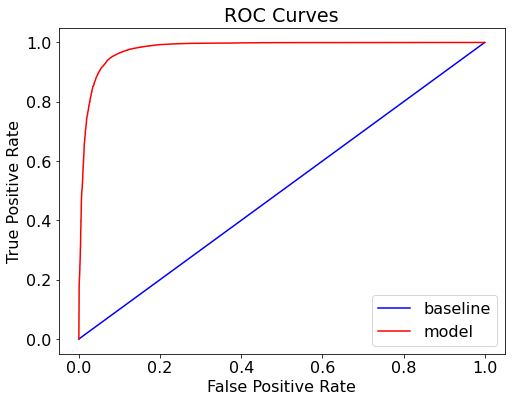

In [72]:
evaluate_model(rf_predictions_new, rf_probs_new, train_rf_predictions_new, train_rf_probs_new)

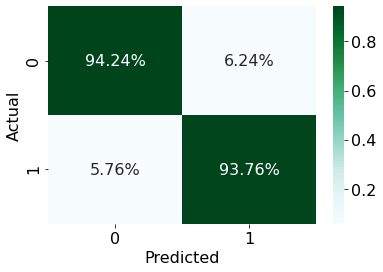

In [73]:
confusion_matrix = pd.crosstab(y_test, rf_predictions_new, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True, 
            fmt='.2%',cmap='BuGn');

In [74]:
from sklearn.metrics import classification_report
print(classification_report(y_test, rf_predictions_new))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92     18385
           1       0.94      0.96      0.95     28615

    accuracy                           0.94     47000
   macro avg       0.94      0.93      0.94     47000
weighted avg       0.94      0.94      0.94     47000



In [75]:
# Model Evaluation metrics 
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
print('Accuracy Score : ' + str(accuracy_score(y_test,rf_predictions_new)))
print('Precision Score : ' + str(precision_score(y_test,rf_predictions_new)))
print('Recall Score : ' + str(recall_score(y_test,rf_predictions_new)))
print('F1 Score : ' + str(f1_score(y_test,rf_predictions_new)))

Accuracy Score : 0.9394255319148936
Precision Score : 0.9376358695652174
Recall Score : 0.9646688799580639
F1 Score : 0.9509602962707777


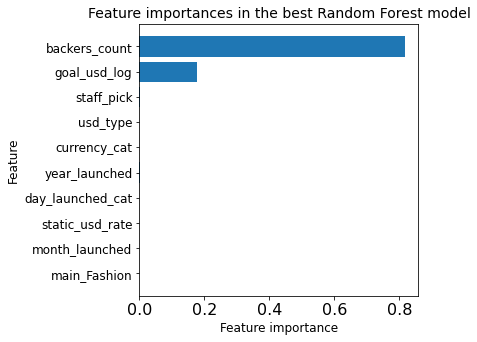

In [76]:
# Plotting feature importance
n_features = X_train.shape[1]
plt.figure(figsize=(5,5))
plt.barh(range(n_features), best_model.feature_importances_, align='center') 
plt.yticks(np.arange(n_features), X_train.columns.values, fontsize=12) 
plt.title("Feature importances in the best Random Forest model", fontsize=14)
plt.xlabel("Feature importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.show()

### Results

After hyperparameter tuning, the all values of our model got worse. More details can be seen at "final model evaluation".

**Before**
- Accuracy Score: 0.9417659574468085
- Precision Score: 0.9398327554558433
- Recall Score: 0.966206535034073
- F1 Score: 0.9528371788465183
- Average number of nodes 20639
- Average maximum depth 33

**After**
- Accuracy Score : 0.9394255319148936
- Precision Score : 0.9376358695652174
- Recall Score : 0.9646688799580639
- F1 Score : 0.9509602962707777
- Average number of nodes 91
- Average maximum depth 7

# Final model evaluation and interpretation

After features selection we've choosen the following features for both models: 
- main_Fashion
- month_launched
- static_usd_rate
- day_launched_cat
- year_launched
- currency_cat
- usd_type
- staff_pick
- goal_usd_log
- backers_count

From beginning the **logistic regression model** had very good accuracy score of around 0.90530 and a f1-score of 0.92310. After hyperparameter tuning, the model's accuracy score could be improved slighty from up to 0.90531 and the f1-score could be improved up to 0.92311. Also the precision got better from 0.991286 up to 0.91298. 

The **random forest model** also had a an even better acuracy of 0.94177 and f1-score of 0.95284. After hyperparmeter tuning, the model's accuracy score got wores to 0.93943 and the f1-score got worse as well to 0.95096. Maybe we need to check that. But still very good values. 

In this case we used for example the feature *backers_count* and *staff_pick*. In case of the very good results we cam up with the result that both of these features can't be known before launching a project. Obviously an easy way to know that we have data leakage is if we are achieving performance that seems a little too good to be true. So we decided to make a new model in the following notebook. 